# What is the value of a customer?

Exploring how we can classify a customer to some particular type.
The plan of attack is to do some:

1. Data exploration.
2. Do PCA to explore distribution of variance.
3. Explore outliers.
4. Cluster using GMM on the transformed.

In [4]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
#import seaborn as sns
#sns.set(font_scale=1.5) 
#sns.set_style("white")

# Pretty display for notebooks
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as grd
import matplotlib.ticker as tkr
import matplotlib.font_manager as font_manager

from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams

#define plotter
minorLocatorx   = AutoMinorLocator(10)
minorLocatory   = AutoMinorLocator(4)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams['axes.linewidth'] = 2.
plt.rcParams['axes.linewidth'] = 4
plt.rc('font', family='serif');
plt.rc('font', serif='Times New Roman'); 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

In [5]:
# Read data
data = pd.read_csv('../ltv20160906_test.csv', delimiter='^')
data_80 = pd.read_csv('../ltv20160906_train.csv', delimiter='^')
data_all = pd.concat([data, data_80])

In [6]:
# convert week into year and week_number column 
data_all['year'] = data_all['week'].apply(lambda y: int(y[0:4]))
data_all['week_number'] = data_all['week'].apply(lambda y: int(y[-2:]))

In [7]:
#consider only US and Dradis data
#rescale costmillicent and then rename it
dataUS = data_all[data_all.jobCountry == 'US']
dataUS = dataUS[dataUS['isDradisEmployer']==1]
dataUS = dataUS.reset_index(drop=True)
dataUS['cost'] = dataUS.costmillicent/1e5

In [8]:
#compute week rank
weekRank = dataUS.groupby('advertiserId')['week'].rank(ascending=True)

In [9]:
#sanity check
print dataUS.shape, weekRank.shape

(2284758, 32) (2284758,)


In [10]:
#add weekRank
dataUS['week_rank'] = weekRank

In [11]:
#clean employee count
dataUS['employeeCount'] = dataUS['employeeCount'].apply(lambda y: '0-' if type(y)!=str else y.replace('+','-'))
print sorted(dataUS.employeeCount.unique())
dataUS['employeeCount'] = dataUS['employeeCount'].apply(lambda y: int(y[0:y.find('-')]))

['0-', '1-49', '1000-', '150-249', '250-499', '50-149', '500-749', '750-999']


In [12]:
# clean industry
dataUS['industry'] = dataUS['industry'].apply(lambda y: 'Blank' if type(y)!=str else y)

In [13]:
# check for double entries
double = dataUS.groupby(['advertiserId','week']).count()
print double.employeeCount.unique() # should be 1

[1]


In [14]:
# check how many weeks does advertiser spend
np.array(set(dataUS.groupby('advertiserId')['week'].count().values))

array(set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]), dtype=object)

In [15]:
# remove data points that does not make sense 
print dataUS.shape
dataUS = dataUS[dataUS.week!='2016-53']
print dataUS.shape

(2284758, 33)
(2259871, 33)


In [16]:
# Sanity check
w = sorted(dataUS.spendAgeWeek_c.unique())
print 'spendAgeWeek_c values'
print w, len(w)
print "Possible values for 'how many weeks an advertiser spend'"
print np.array(set(dataUS.groupby('advertiserId')['week'].count().values))

spendAgeWeek_c values
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79] 82
Possible values for 'how many weeks an advertiser spend'
set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])


In [17]:
#filter out SpendAgeWeek_c <0
dataUS = dataUS[(dataUS['spendAgeWeek_c']<74)&(dataUS['spendAgeWeek_c']>=0)]

In [18]:
# Sanity check
w = sorted(dataUS.spendAgeWeek_c.unique())
print 'spendAgeWeek_c values'
print w, len(w)
print "Possible values for 'how many weeks an advertiser spend'"
print np.array(set(dataUS.groupby('advertiserId')['week'].count().values))

spendAgeWeek_c values
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73] 74
Possible values for 'how many weeks an advertiser spend'
set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74])


In [19]:
dataUS.columns

Index([u'advertiserId', u'isDradisEmployer', u'salesTouched', u'week',
       u'costmillicent', u'jobCountry', u'company', u'employeeCount',
       u'dateCreated', u'firstRevenueDate', u'lastRevenueDate', u'isAdAgency',
       u'industry', u'type', u'state', u'city', u'conversionTime',
       u'hasDradisJob', u'sid', u'kw', u'outgoingEmail', u'outgoingCall',
       u'advertiserAgeWeek', u'spendAgeWeek', u'spendAgeWeek_c',
       u'advertiserAgeWeek_c', u'conversionTime_c', u'sales_touch', u'source',
       u'year', u'week_number', u'cost', u'week_rank'],
      dtype='object')

In [20]:
dataUS.sort_values(['advertiserId', 'week'], ascending=[1, 1], inplace=True)

In [21]:
# Sanity Check
xy = dataUS.groupby('advertiserId')['cost'].sum().values
#sns.distplot(np.log10(xy))
print np.median(xy),np.mean(xy)

270.065 1027.91784788


In [22]:
#pick only important columns
data_clean = dataUS[['advertiserId','week', 'week_rank', 'spendAgeWeek_c', 'cost', 'employeeCount', 'isAdAgency',
                 'industry', 'type', 'source', 'salesTouched']]

In [23]:
#sanity_check : should have the same rows
print data_clean.shape, dataUS.shape

(2256794, 11) (2256794, 33)


In [24]:
# Sanity Check: Advertiser are not label twice
advertisers = data_clean.groupby(['advertiserId']).count()
advertisers_with_info = data_clean.groupby(['advertiserId', 'employeeCount', 'isAdAgency', 'industry',
                                            'type', 'source', 'salesTouched']).count() 
print 'Total advertisers:', advertisers.shape
print 'Total advertisers with labels:', advertisers_with_info.shape

Total advertisers: (224734, 10)
Total advertisers with labels: (224734, 4)


In [25]:
data_clean['first_four_weeks'] = data_clean['spendAgeWeek_c'].apply(lambda y: 1.0 if y<4 else 0.)

/Users/gmsardane/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [26]:
data_clean['cost_first_four_weeks'] = data_clean['first_four_weeks']*data_clean['cost']

/Users/gmsardane/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [27]:
#sanity_check : should have the same rows
print data_clean.shape, dataUS.shape

(2256794, 13) (2256794, 33)


In [28]:
#Aggregate data
agg_data = data_clean.groupby(['advertiserId', 'employeeCount', 'isAdAgency', 'industry',
                                            'type', 'source', 'salesTouched']).sum() 

In [29]:
agg_data.reset_index(inplace=True)

In [30]:
agg_data = agg_data[['advertiserId', 'employeeCount', 'isAdAgency', 'industry',
                                            'type', 'source', 'salesTouched', 'cost', 'cost_first_four_weeks']]

In [31]:
agg_data.head()

,advertiserId,employeeCount,isAdAgency,industry,type,source,salesTouched,cost,cost_first_four_weeks
0,2505904,1,0,Other,Direct Employer,organic,1,24.56,24.56
1,2505922,0,0,Hospitality/Travel,Direct Employer,others,0,442.49,92.28
2,2505985,1,0,Spam,Direct Employer,others,1,200.32,187.42
3,2506047,1,0,Blank,none,organic,0,11.31,11.31
4,2506048,1,0,Blank,Direct Employer,organic,0,320.82,115.98


In [32]:
cost_data = agg_data['cost'].values

In [33]:
#sns.distplot(np.log10(cost_data))
print np.median(cost_data),np.mean(cost_data)
print np.median(np.log10(cost_data)),np.mean(np.log10(cost_data))
print 10.**np.median(np.log10(cost_data)),10.**np.mean(np.log10(cost_data))

270.065 1027.91784788
2.43146830388 2.41289335352
270.064999954 258.75774249


In [34]:
complete_data = dataUS[dataUS['spendAgeWeek_c']==73]

In [35]:
complete_data.shape

(1394, 33)

In [36]:
data_with_full_run = dataUS[dataUS['advertiserId'].isin(sorted(complete_data.advertiserId.unique()))]
data_with_full_run_early = data_with_full_run[data_with_full_run['spendAgeWeek_c']==0]

In [37]:
print sorted(data_with_full_run_early.week.unique())

['2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11']


In [38]:
advertiser_complete_cycle = sorted(complete_data.advertiserId.unique())

In [39]:
advertiser_incomplete_cycle = list(set(agg_data.advertiserId.unique()) - set(advertiser_complete_cycle))

In [40]:
print len(advertiser_complete_cycle), len(advertiser_incomplete_cycle)

1394 223340


### CLEAN DATA FINALLY!

In [171]:
test_data = agg_data[agg_data['advertiserId'].isin(advertiser_complete_cycle)]

In [174]:
to_be_predicted_data = agg_data[agg_data['advertiserId'].isin(advertiser_incomplete_cycle)]
to_be_predicted_data_google = to_be_predicted_data[to_be_predicted_data['source'] == 'google search']

In [175]:
print test_data.shape, to_be_predicted_data.shape
to_be_predicted_data.head()

(1394, 9) (223340, 9)


,advertiserId,employeeCount,isAdAgency,industry,type,source,salesTouched,cost,cost_first_four_weeks
0,2505904,1,0,Other,Direct Employer,organic,1,24.56,24.56
1,2505922,0,0,Hospitality/Travel,Direct Employer,others,0,442.49,92.28
2,2505985,1,0,Spam,Direct Employer,others,1,200.32,187.42
3,2506047,1,0,Blank,none,organic,0,11.31,11.31
4,2506048,1,0,Blank,Direct Employer,organic,0,320.82,115.98


### Define Functions necessary for preprocessing and training.

In [44]:
#Make dummies for categorical features.
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'GarageCond' => 'GarageCond_Ex', etc.
            col_data = pd.get_dummies(col_data, prefix = col)  
        if col == 'cost_first_four_weeks':
            col_data = col_data.replace(0, 1)
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

In [45]:
def remove_nans(df):
    nan_df = df[pd.isnull(df).any(axis=1)]
    for col in nan_df.columns:
        tmp = nan_df[col][pd.isnull(nan_df[col])]
        if len(tmp) >= 1:
            #print "These features have NULLs to signify the absence of such a feature:"
            print col, len(tmp)
            df[col] = df[col].fillna(1.)
    print np.shape(df)
    return df

In [46]:
## Define and remove repeat outliers
def remove_outliers(df):
    outliers  = []
    for feature in df.columns:
        
        # Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(df[feature], 25)
        
        # Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(df[feature], 75)
        
        # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3-Q1)
        
        outliers = list(outliers + df[~((df[feature] >= Q1 - step) & \
                                                  (df[feature] <= Q3 + step))].index.tolist())
    
    # Select the indices for data points you wish to remove
    from collections import Counter
    counts = Counter(outliers)
    outliers = sorted([value for value, count in counts.items() if count > 2])
    return outliers

## Preprocess data

In [176]:
## Preprocess features with NaNs and Catgoricals
test_data_google = to_be_predicted_data_google.drop(['advertiserId', 'industry', 'source'], axis=1)
data_clean = remove_nans(test_data_google)
data_clean = preprocess_features(test_data_google)
print data_clean.shape
data_clean.head()

(5621, 6)
(5621, 9)


,employeeCount,isAdAgency,type_Direct Employer,type_Other,type_Staffing Agency,type_none,salesTouched,cost,cost_first_four_weeks
26,250,0,1.0,0.0,0.0,0.0,1,191.75,131.52
87,0,0,1.0,0.0,0.0,0.0,1,409.36,381.85
167,1,0,0.0,0.0,0.0,1.0,0,60.58,60.58
466,1,0,0.0,0.0,0.0,1.0,0,109.97,109.97
927,1,0,1.0,0.0,0.0,0.0,0,288.85,287.01


In [177]:
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

def create_sets(X, y):
    # Split into training and testing components first
    
    # Set the number of training points
    num_train = int(round(0.80*len(X)))
    
    # Set the number of testing points
    num_test = X.shape[0] - num_train
    
    # Shuffle and split the dataset into the number of training and testing points above
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = num_train, random_state=123458)
    
    # Show the results of the split
    print "Training set has {} samples.".format(X_train.shape[0])
    print "Testing set has {} samples.".format(X_test.shape[0])
    return X_train, X_test, y_train, y_test


In [178]:
def fit_model(X, y, n_estimators = 1000, min_samples_leaf = 1, min_samples_split =2):
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20)
    regressor = GradientBoostingRegressor(loss= 'lad', n_estimators=n_estimators,min_samples_leaf = 1, 
                                          min_samples_split =2,random_state=102345)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'learning_rate': [0.01, 0.02, 0.05, 0.1], # 'n_estimators': [100, 500, 1000],
              'max_depth': [2, 3, 4, 5, 6], 'min_samples_leaf':  [2,3,5,7]}
    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)
    # Create the grid search object
    grid = GridSearchCV(regressor, params, cv=cv_sets, scoring = scoring_fnc)#, verbose=10)
    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    # Print the optimal model after fitting the data
    print 'The cross-validation scores = {:.2f}'.format(grid.best_score_)
    print grid.best_estimator_
    return grid

### Try binning dataset

In [179]:
to_be_predicted_data.loc[to_be_predicted_data['cost_first_four_weeks'] == 0, 'cost_first_four_weeks'] = 1e-3

In [180]:
to_bin = np.log10(to_be_predicted_data[['cost', 'cost_first_four_weeks']])
to_bin.head()

,cost,cost_first_four_weeks
0,1.390228,1.390228
1,2.645903,1.965108
2,2.301724,2.272816
3,1.053463,1.053463
4,2.506261,2.064383


In [181]:
np.shape(to_bin)

(223340, 2)

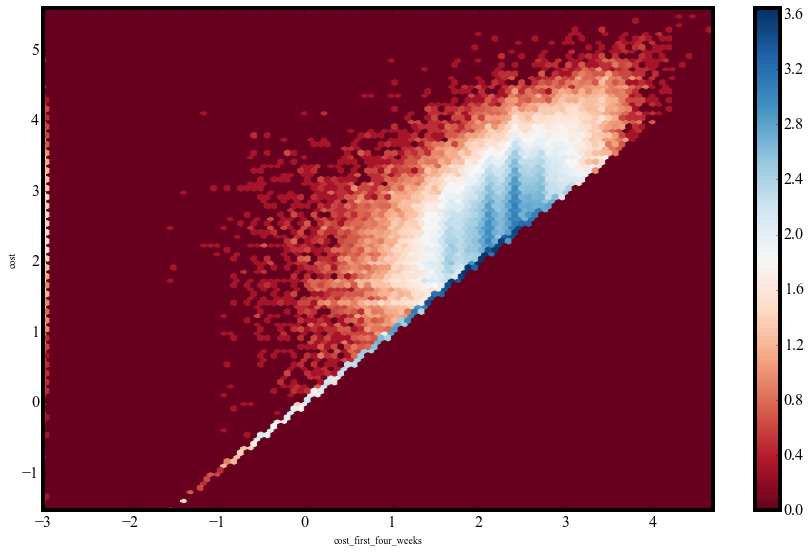

In [53]:
plt.hexbin(to_bin.cost_first_four_weeks, to_bin.cost,  bins='log', cmap=plt.cm.RdBu)
cb = plt.colorbar()
cb.set_label('')
plt.xlabel('cost_first_four_weeks')
plt.ylabel('cost')


In [54]:
hist, bin_edges = np.histogram(to_bin['cost_first_four_weeks'], bins=100)

In [55]:
categories = pd.cut(to_bin['cost_first_four_weeks'], bin_edges)
to_bin['categories'] = pd.cut(to_bin['cost_first_four_weeks'], bin_edges)
to_bin.head()

,cost,cost_first_four_weeks,categories
0,1.390228,1.390228,"(1.383, 1.46]"
1,2.645903,1.965108,"(1.921, 1.998]"
2,2.301724,2.272816,"(2.229, 2.306]"
3,1.053463,1.053463,"(0.998, 1.0753]"
4,2.506261,2.064383,"(1.998, 2.0749]"


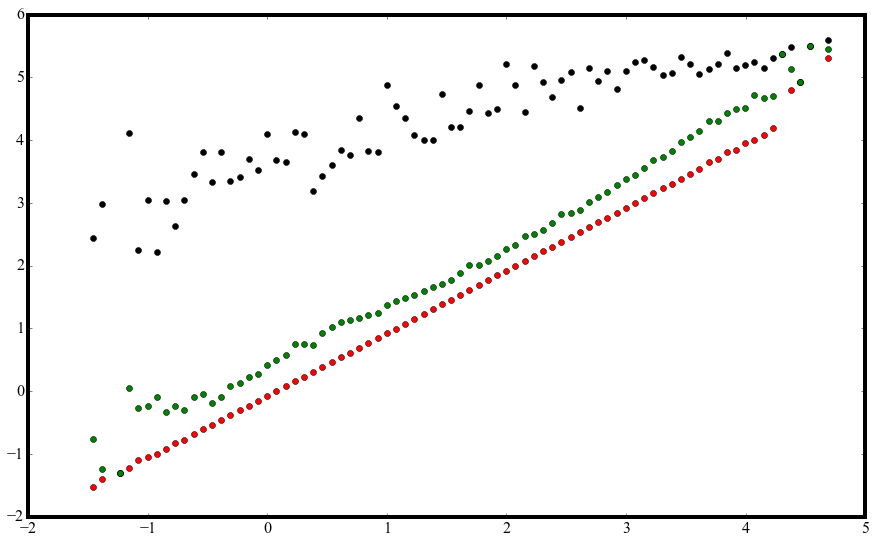

In [56]:
g = pd.groupby(to_bin['cost'], to_bin['categories'])
mean2 = g.mean()
std2 = g.std(0)
medians2 =  g.median()
mins = g.min()
maxs = g.max()
plt.plot(bin_edges[1:], mins, 'ro');
plt.plot(bin_edges[1:], maxs, 'ko');
plt.plot(bin_edges[1:], mean2, 'go');

In [57]:
n, xbins = np.histogram(to_bin.cost_first_four_weeks, bins=100)
sy, _ = np.histogram(to_bin.cost_first_four_weeks, bins=xbins, weights=to_bin.cost)
sy2, _ = np.histogram(to_bin.cost_first_four_weeks, bins=xbins, weights=to_bin.cost*to_bin.cost)

mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

                 Results: Weigthed least squares
Model:              WLS              Adj. R-squared:     0.956   
Dependent Variable: cost             AIC:                20.0362 
Date:               2016-10-18 16:10 BIC:                23.9768 
No. Observations:   53               Log-Likelihood:     -8.0181 
Df Model:           1                F-statistic:        1144.   
Df Residuals:       51               Prob (F-statistic): 1.34e-36
R-squared:          0.957            Scale:              0.082345
--------------------------------------------------------------------
         Coef.     Std.Err.       t       P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const    0.2928      0.0583     5.0195    0.0000    0.1757    0.4099
x1       1.9969      0.0590    33.8217    0.0000    1.8784    2.1154
-----------------------------------------------------------------
Omnibus:             62.319       Durbin-Watson:          1.983  
Prob(Omnibus

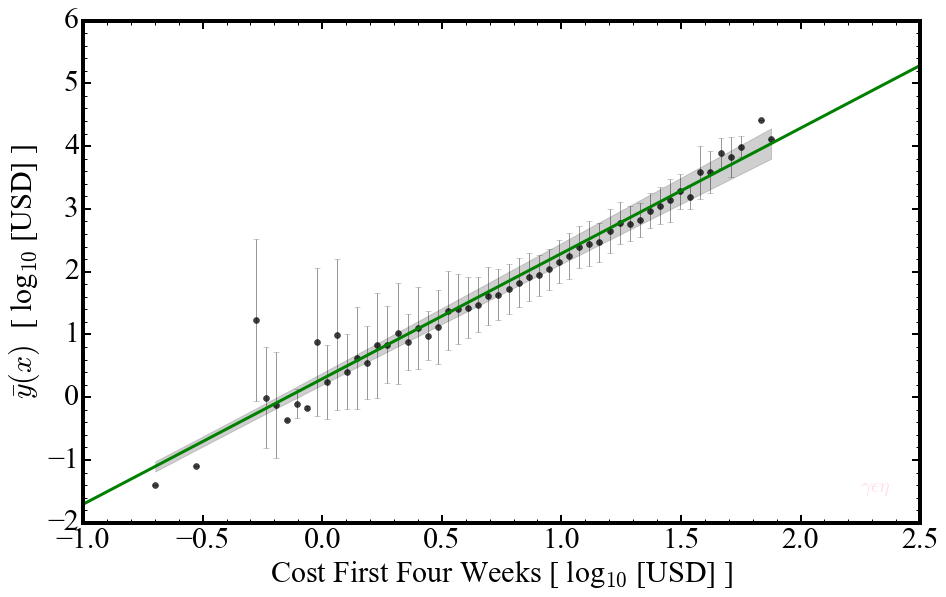

In [158]:
#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
#sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

plt.plot(bin_edges[1:]*0.5, mean2,  'ko', alpha=0.75)
#plt.fill_between(bin_edges[1:]*0.5, mins, maxs, color='#888888', alpha=0.4)
plt.xlabel(r'Cost First Four Weeks [ log$_{10}$ [USD] ]', fontsize = 30)
plt.ylabel(r'$\bar y(x)$' + r'  [ log$_{10}$ [USD] ]', fontsize = 30)
plt.errorbar(bin_edges[1:]*0.5, mean2, yerr=std2, fmt=None, ecolor = 'black', alpha=0.4)
plt.minorticks_on()
plt.tick_params(axis='both',color='k',length=8,width=2, labelsize=30)
plt.tick_params(which='minor',axis='both', color='k',length=4,width=1)
plt.xlim(-1.0, 2.5)
plt.ylim(-2.0, 6)

#Fit a line through these points.
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats

good_means = mean2[np.isfinite(mean2.tolist())]
x = 0.5*bin_edges[1:]
good_x = x[np.isfinite(mean2.tolist())]
good_wgts = std2[np.isfinite(mean2.tolist())]
model = sm.WLS(good_means, sm.add_constant(good_x))
fitted = model.fit()
#sdev, lower, upper = wls_prediction_std(fitted)
W = np.arange(-1, 3.5, 0.1)
plt.plot(W, fitted.params[0] + W*fitted.params[1], 'g-', linewidth=3)
print fitted.summary2()

#Plotting the 95% confidence interval for the line above.
y_hat = good_x*fitted.params[1] + fitted.params[0]
y_err = good_means - y_hat
mean_centers = good_x.T[1].mean()
n = len(good_x)
dof = n - 2 
t = stats.t.ppf(1-0.025, df=dof) #95% CONFIDENCE INTERVAL FOR THE REGRRESSION LINE.
s_err = np.sum(np.power(y_err, 2))
conf = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((good_x-mean_centers),2)/((np.sum(np.power(good_x,2))) - n*(np.power(mean_centers,2))))))
upper = good_x*fitted.params[1] + fitted.params[0] + abs(conf)
lower = good_x*fitted.params[1] + fitted.params[0] - abs(conf)
plt.fill_between(good_x, lower, upper, color='#888888', alpha=0.4)
plt.annotate(r'$\gamma\epsilon\eta$', xy=(2, 1), xytext=(2.25, -1.5), fontsize = 20, alpha=0.5, color='pink')

In [187]:
test_data.shape

(1394, 9)

In [189]:
test_data.loc[test_data['cost_first_four_weeks'] == 0, 'cost_first_four_weeks'] = 1e-3
to_bin_1k = np.log10(test_data[['cost', 'cost_first_four_weeks']])
hist, bin_edges = np.histogram(to_bin_1k['cost_first_four_weeks'], bins=80)
categories = pd.cut(to_bin_1k['cost_first_four_weeks'], bin_edges)
to_bin_1k['categories'] = pd.cut(to_bin_1k['cost_first_four_weeks'], bin_edges)
to_bin_1k.head()

(1394, 9)


,cost,cost_first_four_weeks,categories
8,3.172185,2.508974,"(2.483, 2.568]"
14,3.764598,2.311966,"(2.23, 2.315]"
22,3.524760,2.491544,"(2.483, 2.568]"
50,3.334641,2.328114,"(2.315, 2.399]"
58,2.187069,1.455606,"(1.387, 1.471]"


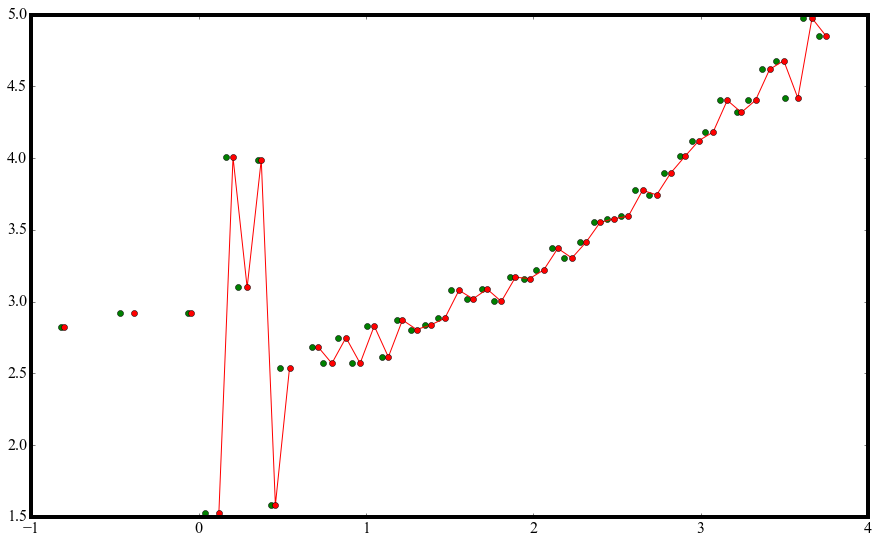

In [184]:
g = pd.groupby(to_bin_1k['cost'], to_bin_1k['categories'])
mean2 = g.mean()
std2 = g.std(0)
medians2 =  g.median()
mins = g.min()
maxs = g.max()
h = pd.groupby(to_bin_1k['cost_first_four_weeks'], to_bin_1k['categories'])
x_means = h.mean()
#plt.plot(bin_edges[1:], mins, 'ro');
#plt.plot(bin_edges[1:], maxs, 'ko');
plt.plot(x_means, mean2, 'go');
plt.plot(bin_edges[1:], mean2, 'r-o');

                  Results: Weigthed least squares
Model:               WLS              Adj. R-squared:     0.962   
Dependent Variable:  cost             AIC:                -10.0693
Date:                2016-10-19 11:01 BIC:                -6.8474 
No. Observations:    37               Log-Likelihood:     7.0346  
Df Model:            1                F-statistic:        912.4   
Df Residuals:        35               Prob (F-statistic): 1.17e-26
R-squared:           0.963            Scale:              0.22855 
------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|  [0.025 0.975]
------------------------------------------------------------------
const                 1.4948   0.0937 15.9567 0.0000 1.3046 1.6850
cost_first_four_weeks 0.9307   0.0308 30.2059 0.0000 0.8682 0.9933
------------------------------------------------------------------
Omnibus:               6.748        Durbin-Watson:           1.002
Prob(Omnibus

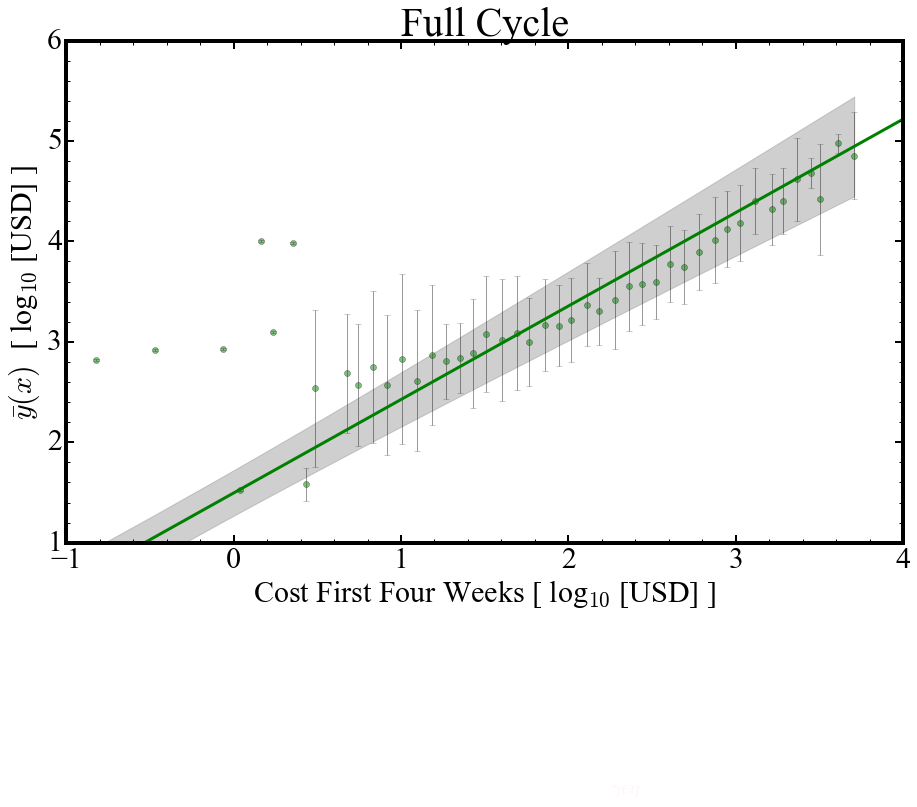

In [202]:
#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
#sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

good_means = mean2[np.isfinite(mean2.tolist())]
x = 0.5*bin_edges[1:]
good_x = x[np.isfinite(mean2.tolist())]
good_xmeans = x_means[np.isfinite(mean2.tolist())]
good_wgts = std2[np.isfinite(mean2.tolist())].replace(0,0.01)

#plt.plot(x[np.isfinite(mean2.tolist())], good_means,  'ko', alpha=0.75)
plt.plot(good_xmeans, good_means, 'go', alpha=0.50);
#plt.fill_between(bin_edges[1:]*0.5, mins, maxs, color='#888888', alpha=0.4)
plt.xlabel(r'Cost First Four Weeks [ log$_{10}$ [USD] ]', fontsize = 30)
plt.ylabel(r'$\bar y(x)$' + r'  [ log$_{10}$ [USD] ]', fontsize = 30)
plt.errorbar(good_xmeans, good_means, yerr=good_wgts, fmt=None, ecolor = 'black', alpha=0.4)
plt.minorticks_on()
plt.tick_params(axis='both',color='k',length=8,width=2, labelsize=30)
plt.tick_params(which='minor',axis='both', color='k',length=4,width=1)
plt.xlim(-1.0, 4)
plt.ylim(+1.0, 6)

#Fit a line through these points.
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats

fit_region = good_xmeans >= 0.5
model = sm.WLS(good_means[fit_region], sm.add_constant(good_xmeans[fit_region]),
               weights=1./good_wgts[fit_region]**2)
fitted = model.fit()
#sdev, lower, upper = wls_prediction_std(fitted)
W = np.arange(-3, 5.5, 0.1)
plt.plot(W, fitted.params[0] + W*fitted.params[1], 'g-', linewidth=3)
print fitted.summary2()

#Plotting the 95% confidence interval for the line above.
y_hat = good_xmeans*fitted.params[1] + fitted.params[0]
y_err = good_means - y_hat
mean_centers = good_xmeans.T[1].mean()
n = len(good_xmeans)
dof = n - 2 
t = stats.t.ppf(1-0.025, df=dof) #95% CONFIDENCE INTERVAL FOR THE REGRRESSION LINE.
s_err = np.sum(np.power(y_err, 2))
conf = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((good_xmeans-mean_centers),2)/((np.sum(np.power(good_xmeans,2))) - n*(np.power(mean_centers,2))))))
upper = good_xmeans*fitted.params[1] + fitted.params[0] + abs(conf)
lower = good_xmeans*fitted.params[1] + fitted.params[0] - abs(conf)
plt.fill_between(good_xmeans, lower, upper, color='#888888', alpha=0.4)
plt.title('Full Cycle', fontsize = 40)
plt.annotate(r'$\gamma\epsilon\eta$', xy=(2, 1), xytext=(2.25, -1.5), fontsize = 20, alpha=0.15, color='pink')


# SEM - only

In [213]:
test_data_SEM = test_data[(test_data.source == 'google search')  | (test_data.source == 'google content')
                          | (test_data.source == 'msn')]
print test_data_SEM.shape
test_data_SEM.head()


(40, 9)


,advertiserId,employeeCount,isAdAgency,industry,type,source,salesTouched,cost,cost_first_four_weeks
708,2518620,50,0,Blank,Direct Employer,msn,0,2477.89,28.08
1061,2525476,1,0,Blank,none,msn,0,128.54,13.34
1851,2536568,50,0,Blank,none,msn,1,153.78,45.04
2381,2545275,150,0,Food/Beverage Services,Direct Employer,msn,1,2225.20,263.28
2389,2545344,1,0,Blank,none,msn,0,129.58,59.22


In [209]:
set(test_data_SEM.source)

{'google content', 'msn'}

In [205]:
test_data.head()

,advertiserId,employeeCount,isAdAgency,industry,type,source,salesTouched,cost,cost_first_four_weeks
8,2506881,1,0,Construction/Engineering,Direct Employer,others,1,1486.57,322.83
14,2507071,1,0,Other,Direct Employer,others,1,5815.64,205.10
22,2507391,1,0,Transportation/Logistics,Direct Employer,others,1,3347.80,310.13
50,2507934,1,0,Technology/Information,Direct Employer,others,1,2160.93,212.87
58,2508051,0,0,Blank,none,others,0,153.84,28.55


In [212]:
set(test_data.source)

{'direct',
 'google content',
 'google search',
 'msn',
 'organic',
 'others',
 'publisher'}

In [130]:
good_x

categories
(-1.48, -1.396]     -1.397940
(-1.143, -1.0584]   -1.096910
(-0.636, -0.552]    -0.586315
(-0.552, -0.467]    -0.485352
(-0.467, -0.383]    -0.423501
(-0.383, -0.299]    -0.361654
(-0.299, -0.214]    -0.238690
(-0.214, -0.13]     -0.166122
(-0.13, -0.0453]    -0.093500
(-0.0453, 0.0391]    0.003352
(0.0391, 0.124]      0.083531
(0.124, 0.208]       0.158646
(0.208, 0.292]       0.259823
(0.292, 0.377]       0.334542
(0.377, 0.461]       0.418249
(0.461, 0.546]       0.507188
(0.546, 0.63]        0.593006
(0.63, 0.714]        0.668453
(0.714, 0.799]       0.758627
(0.799, 0.883]       0.837879
(0.883, 0.968]       0.925228
(0.968, 1.0521]      1.007383
(1.0521, 1.137]      1.088737
(1.137, 1.221]       1.181780
(1.221, 1.305]       1.261957
(1.305, 1.39]        1.349041
(1.39, 1.474]        1.426926
(1.474, 1.559]       1.519941
(1.559, 1.643]       1.607730
(1.643, 1.727]       1.687541
(1.727, 1.812]       1.770532
(1.812, 1.896]       1.852753
(1.896, 1.981]       1.936780